# searching + downloading sentinel data using sentinelsat

## overview
Up to now, you have gained some experience working with basic features of python, used cartopy and matplotlib to create a map, explored using shapely and geopandas to work with vector data, and explored using rasterio and numpy to work with raster data. 

In this example, we'll see how we can use an application programming interface (API) to query and download Sentinel data, using the [SentinelSat](https://sentinelsat.readthedocs.io/en/stable/) API. As part of this, we'll also introduce a few more geometric operations using `shapely` that you may find useful.

## objectives

In this example, you will:

-  Use `shapely` to get the _unary union_ of a collection of shapes
-  Use `shapely` to find the minimum bounding rectangle of a geometry
-  Use the SentinelAPI to search for Sentinel-2 images
-  Calculate the fractional overlap between shapes
-  Use the SentinelAPI to download images

## data provided

In this example, we will be using the `Counties` shapefile that we used in Week 2.

## getting started

To get started, run the following cell to import the packages that we'll use in the practical.

In [1]:
import os
import geopandas as gpd
from sentinelsat import SentinelAPI, make_path_filter
from IPython import display # lets us display images that we download
import shapely
import requests
import netrc

## preparing a search area

Before we get to using the API to search for images, we'll see how we can use existing data, like the `Counties` shapefile we used in Week 2, to help us search for images.

We won't be able to use particularly complicated shapes, but we can use a combination of GIS/geometric operations to get a simple outline of our data, which can be used for the search.

First, we'll load the data using `geopandas`, making sure to transform from the original CRS to WGS84 latitude/longitude (`epsg=4326`):

In [2]:
counties = gpd.read_file('../Week2/data_files/Counties.shp').to_crs(epsg=4326)

Next, we'll use the `geopandas.Series.unary_union` attribute ([documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.unary_union.html)) to get a combination of all of the County outlines in a single geometry feature:

In [ ]:
# gets a single polygon (or multipolygon) composed of the individual polygons
outline = counties['geometry'].unary_union

outline # note that in a jupyter notebook, this actually displays the polygon.

In the output of the cell above, we can see that the `outline` shape is indeed the combination of all of the individual county outlines.

We could use this as an input to our search, but we'll look at one additional attribute of a `shapely` **Polygon** that we can use to get a bounding box of the geometry - the `minimum_rotated_rectangle` ([documentation](https://shapely.readthedocs.io/en/stable/reference/shapely.minimum_rotated_rectangle.html)):

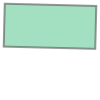

In [4]:
# gets the minimum rotated rectangle that covers the outline
search_area = outline.minimum_rotated_rectangle

search_area

You can see above that this gives a boundary box of the polygon, but rather than being a simple rectangle made of the maximum/minimum coordinates, it's rotated to be as small as possible while still covering the entire geometry. 

This way, we minimize the area outside of the area of interest (Northern Ireland) within our search area, while still making sure to cover the entire area of interest.

Finally, if we look at the docstring for `SentinelAPI.query()` ([documentation](https://sentinelsat.readthedocs.io/en/latest/api_reference.html#sentinelsat.sentinel.SentinelAPI.query)), we see that the `area` argument needs to be a `str`:

In [5]:
help(SentinelAPI.query)

Help on function query in module sentinelsat.sentinel:

query(self, area=None, date=None, raw=None, area_relation='Intersects', order_by=None, limit=None, offset=0, **keywords)
    Query the OpenSearch API with the coordinates of an area, a date interval
    and any other search keywords accepted by the API.

    Parameters
    ----------
    area : str, optional
        The area of interest formatted as a Well-Known Text string.
    date : tuple of (str or datetime) or str, optional
        A time interval filter based on the Sensing Start Time of the products.
        Expects a tuple of (start, end), e.g. ("NOW-1DAY", "NOW").
        The timestamps can be either a Python datetime or a string in one of the
        following formats:

            - yyyyMMdd
            - yyyy-MM-ddThh:mm:ss.SSSZ (ISO-8601)
            - yyyy-MM-ddThh:mm:ssZ
            - NOW
            - NOW-<n>DAY(S) (or HOUR(S), MONTH(S), etc.)
            - NOW+<n>DAY(S)
            - yyyy-MM-ddThh:mm:ssZ-<n>DAY(S)

Specifically, it needs to be a ["Well-Known Text (WKT)"](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) representation of the geometry. 

For a `shapely` geometry, the WKT representation of the geometry is stored in the `wkt` attribute:

In [6]:
# displays the search area wkt
print(search_area.wkt)

POLYGON ((-5.444578058013133 54.00753276745063, -8.18708110521104 54.07491705166869, -8.155505216389793 55.36003823853238, -5.413002169191886 55.292653954314325, -5.444578058013133 54.00753276745063))


That's all we need to be able to search for images that intersect with a given geometry. Once we have this, we can connect to the API and start the query.

## searching the archive for images

### connecting to the api

To connect to the API, we first create a **SentinelAPI** object ([documentation](https://sentinelsat.readthedocs.io/en/latest/api_reference.html#sentinelsat.sentinel.SentinelAPI)):

In [7]:
url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
headers = {
    "Content-Type": "application/x-www-form-urlencoded"
}

# Specify the path to the .netrc file
netrc_file_path = r"C:\Users\kinse\.netrc.txt"

# Load credentials from .netrc file
credentials = netrc.netrc(netrc_file_path).authenticators("identity.dataspace.copernicus.eu")

if credentials:
    username, _, password = credentials
    data = {
        "username": username,
        "password": password,
        "grant_type": "password",
        "client_id": "cdse-public"
    }

    response = requests.post(url, headers=headers, data=data)
    print(response.json())
else:
    print("Credentials not found in .netrc file.")


{'access_token': 'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJYVUh3VWZKaHVDVWo0X3k4ZF8xM0hxWXBYMFdwdDd2anhob2FPLUxzREZFIn0.eyJleHAiOjE3MTIwMDk1NzUsImlhdCI6MTcxMjAwODk3NSwianRpIjoiMWNmOWJmY2EtMWExMi00NTk1LTg1N2YtOWRhYWMzZDY1MTgwIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5kYXRhc3BhY2UuY29wZXJuaWN1cy5ldS9hdXRoL3JlYWxtcy9DRFNFIiwiYXVkIjpbIkNMT1VERkVSUk9fUFVCTElDIiwiYWNjb3VudCJdLCJzdWIiOiI4ZjIxMWZlYi1mOGZiLTRjMzgtODJkMC02ZjRjMjYyZjQxNDQiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJjZHNlLXB1YmxpYyIsInNlc3Npb25fc3RhdGUiOiI5MDA0MGFkOC1lZGRjLTQ1MjAtYTUwZS05ODkxNDExN2Y2NjgiLCJhbGxvd2VkLW9yaWdpbnMiOlsiaHR0cHM6Ly9sb2NhbGhvc3Q6NDIwMCIsIioiLCJodHRwczovL3dvcmtzcGFjZS5zdGFnaW5nLWNkc2UtZGF0YS1leHBsb3Jlci5hcHBzLnN0YWdpbmcuaW50cmEuY2xvdWRmZXJyby5jb20iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLWNkYXMiLCJjb3Blcm5pY3VzLWdlbmVyYWwiXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LC

From the API reference for `sentinelsat`, we can see that we either type in the username and password as a string (**a terrible idea - don't do this!**), or we use `None` to use the `.netrc` file that we created earlier.

If there are no error messages or warnings, the connection was successfully created, and we can move on to searching for images.

### searching for images

As we saw earlier, the method we'll use is `api.query()`.

For this example, we'll use the following arguments for the search:

- `area`: the search area to use
- `date`: the date range to use. We'll look for all images from February 2023.
- `platformname`: we're going to limit our search to Sentinel-2, but note that there are other options available
- `producttype`: we'll search for the Sentinel-2 MSI Level 2A (surface reflectance) products
- `cloudcoverpercentage`: we want (mostly) cloud-free images, so we'll search for images with < 30% cloud cover

To see what additional arguments are available, you can check the [SentinelAPI](https://sentinelsat.readthedocs.io/en/latest/api_reference.html#sentinelsat.sentinel.SentinelAPI.query) API reference, or the [Open Access Hub](https://scihub.copernicus.eu/twiki/do/view/SciHubUserGuide/FullTextSearch?redirectedfrom=SciHubUserGuide.3FullTextSearch) API reference for additional keywords to use.

In [12]:
aoi = "POLYGON((4.220581 50.958859,4.521264 50.953236,4.545977 50.906064,4.541858 50.802029,4.489685 50.763825,4.23843 50.767734,4.192435 50.806369,4.189689 50.907363,4.220581 50.958859))'"


The output of `api.query()` is a **dict** object, with the product name the `key` and the `value` being the metadata. 

To see how many images were returned by the search, we can check the length of the **dict** object, which tells us the number of `item`s (`key`/`value` pairs) in the **dict**:

In [11]:
# Define your variables
data_collection = "SENTINEL-2"
aoi = "POLYGON((4.220581 50.958859,4.521264 50.953236,4.545977 50.906064,4.541858 50.802029,4.489685 50.763825,4.23843 50.767734,4.192435 50.806369,4.189689 50.907363,4.220581 50.958859))"
start_date = "2022-06-01"
end_date = "2022-06-10"

# Make the request to the API
json_data = requests.get(f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq '{data_collection}' and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}) and ContentDate/Start gt {start_date}T00:00:00.000Z and ContentDate/Start lt {end_date}T00:00:00.000Z").json()

# Create a DataFrame from the JSON data
df = gpd.GeoDataFrame.from_dict(json_data['value'])

# Display the first 5 rows of the DataFrame
print(df.head(5))


{'detail': {'message': 'Error during parsing at index 71',
            'request_id': 'c34f9851-0784-4366-8274-2b7ecf679d07'}}


You should hopefully see that the search has returned 11 results. 

To look at the first one returned, we can use the built-ins `next()` ([documentation](https://docs.python.org/3/library/functions.html#next)) and `iter()` ([documentation](https://docs.python.org/3/library/functions.html#iter)), which returns the first item that was entered into the **dict**:

In [ ]:
import random

# List of scenes
scenes = [
    {
        "Id": "550c10a8-3a31-5f28-8d68-e0b7086dbc8f",
        "Name": "S2B_MSIL2A_20220601T103629_N0400_R008_T31UFS_2...",
        "ContentDate": "2022-06-01T10:36:29.024Z",
        "Footprint": "geography'SRID=4326;POLYGON ((4.4362457433229 ...)"
    },
    {
        "Id": "f83b6e00-8669-5f6c-96e1-f8c82dd98909",
        "Name": "S2B_MSIL1C_20220601T103629_N0400_R008_T31UES_2...",
        "ContentDate": "2022-06-01T10:36:29.024Z",
        "Footprint": "geography'SRID=4326;POLYGON ((4.0716897587579 ...)"
    },
    # Add more scenes as needed
]

# Randomly select one scene
selected_scene = random.choice(scenes)

# Print the selected scene's details
print("Selected Scene:")
print("ID:", selected_scene["Id"])
print("Name:", selected_scene["Name"])
print("Content Date:", selected_scene["ContentDate"])
print("Footprint:", selected_scene["Footprint"])


And, we can also download the browse image for this product, using `SentinelAPI.download_quicklook()` ([documentation](https://sentinelsat.readthedocs.io/en/latest/api_reference.html#sentinelsat.sentinel.SentinelAPI.download_quicklook)):

In [ ]:
qlook = api.download_quicklook(result) # download the quicklook image for the first result
display.Image(qlook['path']) # display the image

In this example, we might notice a small problem - while this image technically does intersect our area of interest, it does so only barely. Northern Ireland is the small bit of land in the lower left-hand corner of this image - most of the image is of Scotland and the Irish Sea.

In the next section, we'll see one way that we can make sure that we're only getting images that mostly intersect with our area of interest.

## filtering by overlap

To start, we use `SentinelAPI.to_geodataframe()` ([documentation](https://sentinelsat.readthedocs.io/en/latest/api_reference.html#sentinelsat.sentinel.SentinelAPI.download_quicklook)) to convert the results into a **GeoDataFrame**:

In [ ]:
product_geo = SentinelAPI.to_geodataframe(products) # convert the search results to a geodataframe
product_geo.head() # show the first 5 rows of the geodataframe

Now, we can iterate over **GeoDataFrame** to calculate the intersection of the image footprint with the outline of Northern Ireland:

In [ ]:
for ind, row in product_geo.iterrows():
    intersection = outline.intersection(row['geometry']) # find the intersection of the two polygons
    product_geo.loc[ind, 'overlap'] = intersection.area / outline.area # get the fractional overlap
    
print(product_geo.overlap) # show the fractional overlap for each index

In this example, the third image, `80558644-2e31-48b9-acd5-5d1475dfc1bf` has 43% overlap with the outline of Northern Ireland; none of the other images have more than 20%.

Rather than copying this down, we can use `geopandas.GeoSeries.argmax()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.argmax.html)) to find the integer location of the largest value in the `overlap` column:

In [ ]:
max_index = product_geo.overlap.argmax() # get the integer location of the largest overlap value
print(max_index) # should be 2

Then, we get the **GeoDataFrame** index that corresponds to that integer location:

In [ ]:
best_overlap = product_geo.index[max_index] # get the actual index (image name) with the largest overlap
print(product_geo.loc[best_overlap]) # show the metadata for the image with the largest overlap

With this, we can use `api.download_quicklook()` ([documentation](https://sentinelsat.readthedocs.io/en/latest/api_reference.html#sentinelsat.sentinel.SentinelAPI.download_quicklook)) to download the quicklook image for the result that has the largest overlap with the outline of Northern Ireland:

In [ ]:
qlook = api.download_quicklook(best_overlap) # download the quicklook image for the first result
display.Image(qlook['path']) # display the image

So that's a little bit better - at least with this image, we can see much more of Northern Ireland (and the ever-present clouds).

That's all for right now - the next few cells provide examples for how you can download the actual image data.

## downloading images

<span style="color:#009fdf;font-size:1.1em;font-weight:bold">Remember that these are very large files (each granule is ~1GB), so you should only run these cells if you actually want to download the data!</span>

### downloading an individual image

We can use `SentinelAPI.download()` ([documentation](https://sentinelsat.readthedocs.io/en/latest/api_reference.html#sentinelsat.sentinel.SentinelAPI.download)) to download a single product, given the Product ID:

In [ ]:
api.download(best_overlap) # downloads the first result

### download an individual image, but only the image bands

This example uses the `nodefilter` argument along with `make_path_filter()` ([documentation](https://sentinelsat.readthedocs.io/en/latest/api_reference.html#sentinelsat.products.make_path_filter)) to only download the image bands (files that match the format `*_B*.jp2`):

In [ ]:
api.download(first_result, # downloads the first result
             nodefilter=make_path_filter("*_B*.jp2")) # only download the image bands (optional)

### download all images from a list of products

Finally, `SentinelAPI.download_all()` ([documentation](https://sentinelsat.readthedocs.io/en/latest/api_reference.html#sentinelsat.sentinel.SentinelAPI.download_all)) will download all of the products in a list. 

<span style="color:#009fdf;font-size:1.1em;font-weight:bold">Again, these are very large files, so you should only run the following cell if you actually want to download all of the images returned by the API!</span>

In [ ]:
api.download_all(products,
                 n_concurrent_dl=5, # allow up to 5 concurrent downloads
                 nodefilter=make_path_filter("*_B*.jp2")) # only down the image bands (optional)